# Advanced Tutorial (geared toward state-space models)

This tutorial covers more or less the same topics as the basic tutorial (filtering, smoothing, and parameter estimation of state-space models), but in greater detail.

## Defining state-space models

We consider a state-space model of the form: 
\begin{align*}
        X_0 & \sim N(0, 1) \\
        X_t & = f(X_{t-1}) + U_t, \quad U_t \sim N(0, \sigma_X^2) \\
        Y_t & = X_t + V_t, \quad   V_t \sim N(0, \sigma_Y^2)
\end{align*}
where function $f$ is defined as follows: $f(x) = \tau_0 - \tau_1 * \exp( \tau_2 * x)$. This model comes from Population Ecology; there $X_t$ stands for the logarithm of the population size of a given species.
This model may be defined as follows.

In [1]:
% matplotlib inline

# the usual imports
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# imports from the package
import pysqmc 
from pysqmc import state_space_models as ssm
from pysqmc import distributions as dists


class ThetaLogistic(ssm.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology). 
    """
    default_params = {'tau0':.15, 'tau1':.12, 'tau2':.1, 'sigmaX': 0.47, 'sigmaY': 0.39}

    def PX0(self):  # Distribution of X_0
        return dists.Normal()
    
    def f(self, x):
        return (x + self.tau0 - self.tau1 * np.exp(self.tau2 * x))
    
    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.Normal(loc=self.f(xp), scale=self.sigmaX)
    
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x, and X_{t-1}=xp
        return dists.Normal(loc=x, scale=self.sigmaY)

This is most similar to what we did in the previous tutorial (for stochastic volatility models): methods `PX0`, `PX` and `PY` return objects defined in module `distributions`. (See the documentatation of that module for a list of available distributions). 

The only novelty is that we defined (as a class attribute) the dictionary  `default_parameters`, which provides default values for each parameter. When it is defined, each parameter that is not set explicitly when instantiating (calling) `ThetaLogistic` is replaced by its default value:

Text(0, 0.5, 'data')

/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


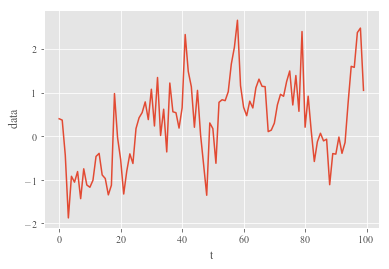

In [2]:
my_ssm = ThetaLogistic()  # use default values for all parameters
x, y = my_ssm.simulate(100)

plt.style.use('ggplot')
plt.plot(y)
plt.xlabel('t')
plt.ylabel('data')

"Bogus Parameters" (parameters that do not appear in `PX0`, `PX` and `PY`) are simply ignored:

In [3]:
just_for_fun = ThetaLogistic(tau2=0.3, bogus=92.)  # ok

This behaviour may look suprising, but it will allow us to define prior distributions that involve hyper-parameters.

## Automatic definition of `FeynmanKac` objects

We have seen in the previous tutorial how to run a bootstrap filter: we first define some `Bootstrap` object, and then passes it to SMC. 

In [4]:
fk_boot = ssm.Bootstrap(ssm=my_ssm, data=y)
my_alg = pysqmc.SMC(fk=fk_boot, N=100)
my_alg.run()

In fact, `ssm.Bootstrap` is a subclass of `FeynmanKac`, the base class for objects that represent "Feynman-Kac models" (covered in Chapters 5 and 10). To make things simple, a Feynman-Kac model is a "recipe" for our SMC algorithms; in particular, it tells us: 

1. how to sample each particle $X_t^n$ at time $t$, given their ancestors $X_{t-1}^n$;
2. how to reweight each particle $X_t^n$ at time $t$. 

The bootstrap filter is a particular "recipe", where:
1. we sample the particles $X_t^n$ according to the state transition of the model; in our case a $N(f(x_{t-1}),\sigma_X^2)$ distribution. 
2. we reweight the particles according to the likelihood of the model; here the density of $N(x_t,\sigma_Y^2)$ at point $y_t$. 

The class `ssm.Bootstrap` defines this recipe automatically from the supplied state-space model and data. 

Of course, the boostrap filter is not the only available "recipe". We may want to run a guided filter, where the particles are simulated according to user-chosen proposal kernels. Such proposal kernels may be defined by adding methods `proposal` and `proposal0` to our `StateSpaceModel` class:

In [5]:
class ThetaLogistic_with_prop(ThetaLogistic):
    def proposal0(self, data):
        return self.PX0()
    def proposal(self, t, xp, data):
        prec_prior = 1. / self.sigmaX**2
        prec_lik = 1. / self.sigmaY**2
        var = 1. / (prec_prior + prec_lik) 
        mu = var * (prec_prior * self.f(xp) + prec_lik * data[t])
        return dists.Normal(loc=mu, scale=np.sqrt(var))

my_better_ssm = ThetaLogistic_with_prop()

In this particular case, we implemented the "optimal" proposal, that is, the distribution of $X_t$ given $X_{t-1}$ and $Y_t$. (Check this is indeed this case, this is a simple exercise!). (For simplicity, the proposal at time 0 is simply the distribution of X_0, so this one is not optimal.)

Now we may define our guided Feynman-Kac model: 

In [6]:
fk_guided = ssm.GuidedPF(ssm=my_better_ssm, data=y)

An APF (auxiliarly particle filter) may be implemented in the same way: for this, we must also define method `logeta`, which computes the auxiliary function used in the resampling step; see the documentation and the end of Chapter 10.

## Running a particle filter

Here is the signature of class `SMC`.  

In [22]:
alg = pysqmc.SMC(fk=fk_guided, N=100, seed=None, ESSrmin=0.5,
                 resampling='systematic', store_history=False, 
                 compute_moments=False, online_smoothing=None, 
                 verbose=False)

Apart from ``fk`` (which expects a `FeynmanKac` object), all the other arguments are optional. Here is what they do: 

* `N`: the number of particles
* `seed`: value used to initialise the pseudo-random generator before the partice filter is run (if None the algorithm is not seeded)
* `resampling`: which resampling scheme to use (possible choices: 'multinomial', 'residual', 'stratified', 'systematic' and 'ssp') 
* `ESSrmin`: the particle filter resamples at each iteration such that ESS / N is below this threshold; set it to one (resp. zero) to resample every time (resp. to never resample)

The remaining arguments (``store_history``, ``compute_moments`` and ``online_smoothing``) will be explained in the following sections. 

Once we have a created a SMC object, we may run it, either step by step, or in one go. For instance: 

In [23]:
next(alg) # processes data-point y_0
next(alg)  # processes data-point y_1
for _ in range(8):
    next(alg)  # processes data-points y_3 to y_9
# alg.run()  # would process all the remaining data-points

At any time, object `alg` has the following attributes:

* `alg.t`: index of next iteration
* `alg.X`: the N current particles $X_t^n$; typically a (N,) or (N,d) [numpy array](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)
* `alg.W`: the N normalised weights $W_t^n$ (a (N,) numpy array)
* `alg.Xp`: the N particles at the previous iteration, $X_{t-1}^n$
* `alg.A`: the N ancestor variables: A[3] = 12 means that the parent of $X_t^3$ was $X_{t-1}^{12}$.
* `alg.summaries`: various summaries collected at each iteration.

Let's do for instance a weighted histogram of the particles. 

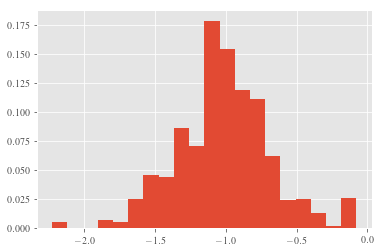

In [24]:
plt.hist(alg.X, 20, weights=alg.W);

Object alg.summaries contains various lists of quantities collected at each iteration, such as:
    * `alg.summaries.ESSs`: the ESS (effective sample size) at each iteration
    * `alg.summaries.rs_flags`: whether or not resampling was triggered at each step
    * `alg.summaries.logLts`: estimates of the log-likelihood of the data $y_{0:t}$ 
    
All this and more is explained in the documentation of the `collectors` module. Let's plot the ESS and the log-likelihood:

Text(0, 0.5, 'ESS')

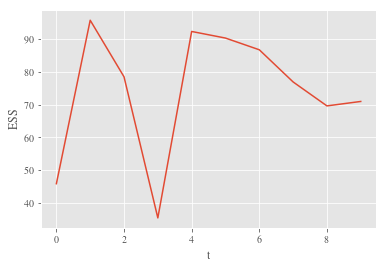

In [25]:
plt.plot(alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

Text(0, 0.5, 'log-likelihood')

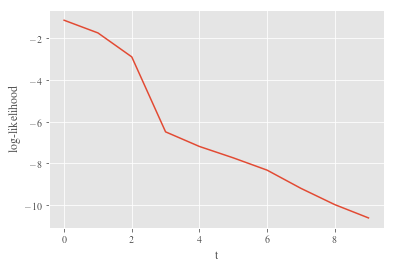

In [26]:
plt.plot(alg.summaries.logLts)
plt.xlabel('t')
plt.ylabel('log-likelihood')

## Running many particle filters in one go

Function multiSMC accepts the same arguments as `SMC` plus the following extra arguments: 

* `nruns`: number of runs 
* `nprocs`: if >0, number of CPU cores to use; if <=0, number of cores *not to* use; i.e. `nprocs=0` means use all cores
* `out_func`: a function that is applied to each resulting particle filter (see below). 

To explain how exactly `multiSMC` works, let's try to compare the bootstrap and guided filters for the theta-logistic model we defined at the beginning of this tutorial:

In [27]:
outf = lambda pf: pf.logLt
results = pysqmc.multiSMC(fk={'boot':fk_boot, 'guid':fk_guided}, nruns=20, nprocs=1, out_func=outf)

The command above runs **40** particle algorithms (on a single core): 20 bootstrap filters, and 20 guided filters. The output, ``results``, is a list of 40 dictionnaries; each dictionary contains the following (key, value) pairs:

* 'model': either 'boot' or 'guid' (according to whether a boostrap or guided filter has been run)
* 'run': a run indicator (between 0 and 19)
* 'output': the result of `outf(pf)` where pf is the SMC object that was run. (If `outf` is set to None, then the SMC object is returned.)

The rationale between function `outf` is that SMC objects may take a lot of memory in certain cases (especially if you set `store_memory to True`, see section on smoothing, below), so we may want to save only some results of interest rather than the complete object itself. Here the output is simply the estimate of the log-likelihood of the (complete) data computed by each particle filter. Let's check if the guided filter provides lower-variance estimates, relative to the bootstrap filter.

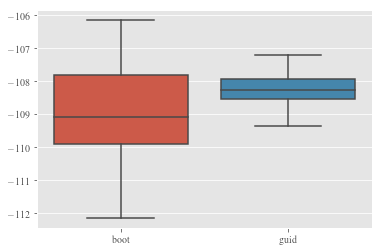

In [28]:
sb.boxplot(x=[r['fk'] for r in results],  y=[r['output'] for r in results])

This is indeed the case. To understand this line of code, you must be a bit familiar with [list comprehensions](http://www.secnetix.de/olli/Python/list_comprehensions.hawk). 

More generally, function `multiSMC` may be used to run multiple SMC algorithms, while varying any possible arguments; for more details, see the documentation of `multiSMC` and of the module `pysqmc.utils`. 

## Summaries, on-line smoothing

We have said that `alg.summaries`  (where `alg` is a SMC objects) contains various **lists** that collect information at each iteration (such as the ESS, the log-likelihood estimates). The following options (of class `SMC`) produce extra summaries:

* `compute_mompents`: if set to True, the weighted, component-wise mean and variance of the particles are computed and stored in a list of dictionaries (with keys 'mean' and 'var'), called `alg.summaries.moments`. 

* `online_smoothing`: may be set to None (no on-line smoothing), 'naive' (standard forward smoothing), or 'ON2' (the $O(N^2)$ version, which is expensive.) 

For more details on on-line smoothing, see the documentation of module `pysqmc.collectors`. 


Let's compute the moments:

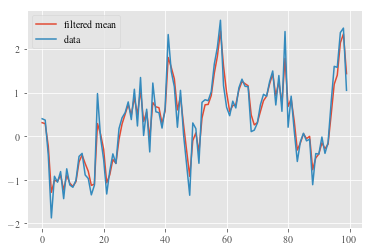

In [29]:
alg_with_mom = pysqmc.SMC(fk=fk_guided, N=100, moments=True)
alg_with_mom.run()

plt.plot([m['mean'] for m in alg_with_mom.summaries.moments], label='filtered mean')
plt.plot(y, label='data')
plt.legend()

## Off-line smoothing
Off-line smoothing is the task of approximating, at some final time $T$ (i.e. when we have stopped acquiring data), the distribution of all the states, $X_{0:T}$, given the full data, $Y_{0:T}$. 

To run a particular off-line smoothing algorithm, one must first run a particle filter, and save its **history**: 

In [30]:
alg = pysqmc.SMC(fk=fk_guided, N=100, store_history=True)
alg.run()

Now `alg` has a `hist` attribute, which is a `ParticleHistory` object. Basically, `alg.hist` recorded, at each time $t$: 
 * the N particles $X_t^n$
 * their weights $W_t^n$
 * the N ancestor variables
 
Smoothing algorithms are implemented as methods of class `ParticleHistory`. For instance, the FFBS (forward filtering backward sampling) algorithm, which samples complete smoothing trajectories, may be called as follows:

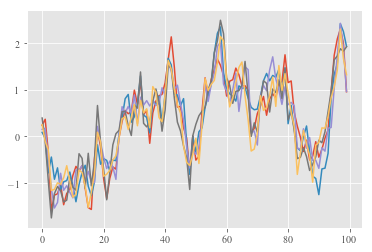

In [31]:
trajectories = alg.hist.backward_sampling(5, linear_cost=False)
plt.plot(trajectories)

The output of `backward_sampling` is a list of 100 arrays: `trajectories[t][m]` is the $t$-component of trajectory $m$. (If you want to turn it into a numpy array, simply do: `np.array(trajectories)`.)

Option `linear_cost` determines whether we use the standard, $O(N^2)$ version of FFBS (where generating a single trajectory costs $O(N)$), or the $O(N)$ version which relies on rejection. The latter algorithm requires us to specify an upper bound for the transition density of $X_t | X_{t-1}$; this may be done by defining a method `upper_bound_trans(self, t)` in the considered state-space model

acceptance rate was 0.321


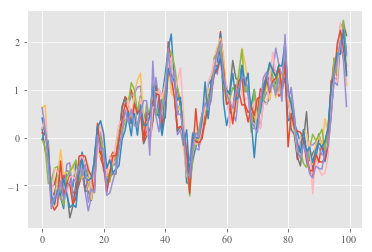

In [32]:
class ThetaLogistic_with_upper_bound(ThetaLogistic_with_prop):
    def upper_bound_log_pt(self, t):
        return -np.log(np.sqrt(2 * np.pi) * self.sigmaX)
    
my_ssm = ThetaLogistic_with_upper_bound()
alg = pysqmc.SMC(fk=ssm.GuidedPF(ssm=my_ssm, data=y), N=100, store_history=True)
alg.run()
(more_trajectories, acc_rate) = alg.hist.backward_sampling(10, linear_cost=True, return_ar=True)

print('acceptance rate was %1.3f' % acc_rate)
plt.plot(more_trajectories)

Two-filter smoothing is also available. The difficulty with two-filter smoothing is that it requires to design an "information filter", that is a particle filter that computes recursively (backwards) the likelihood of the model. Since this is not trivial for the model considered here, we refer to Section 11.6 of the book and the documentation of package `smoothing`.